# 0. Setup

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-9d5e4f83-3f58-2974-ee70-21df15226f84)


In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from misc.helpers import calculate_true_distributions
import numpy as np
import pandas as pd


from model.vit_for_small_dataset import ViT
from utils.imageset_handler import ImageQualityDataset

# 1. Build Model

### 1.1 Define Variables

In [2]:
image_size=256
patch_size=16
num_classes=5  # Number of classes for image quality levels
dim=1024
depth=6
heads=16
mlp_dim=2048
emb_dropout=0.1


pretrained_model_path = None
# pretrained_model_path = 'results/weights/all_distored_imgs_1/vit_model_20230911_064440_epoch_148of150_valLoss_0.108_valAcc_0.953_batchsize_128_lr_0.0_allDistorted.pth'
num_epochs = 100
results_path = './results/weights/AIO0'
os.makedirs(results_path, exist_ok=True)

dataset_root = 'assets/Dataset/DS0'
csv_file = 'assets/Dataset/Obs0.csv'

### 1.2 Compile

In [18]:
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)
print(model)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

### 1.3 Load pretrained weights

In [19]:
if pretrained_model_path:
    model.load_state_dict(torch.load(pretrained_model_path))
    print(model)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((3840,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3840, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (

# 2 Load Dataset

### 2.1 Add Augmentation (Transformation)

In [3]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

### 2.2 Create Dataset

In [21]:
dataset = ImageQualityDataset(csv_file,dataset_root,transform=transform)

Number of images in the dataset: 898


### 2.3 Split the dataset into training and validation sets

In [22]:
test_size = 0.2
num_train = int(len(dataset)* (1-test_size))
num_val = len(dataset) - num_train

print('Splitting Dataset..')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [num_train, num_val])

print(f"Number of Data to train: {num_train}")
print(f"Number of Data to validate: {num_val}")

Splitting Dataset..
Number of Data to train: 718
Number of Data to validate: 180


# 3. Train

### 3.1 Define Training Parameters

In [23]:
learning_rate = 5e-5
batch_size = 128

### 3.2 Init Optimizer, loss function and dataloader

In [24]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
mse_criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### 3.3 Train-Loop

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
best_val_loss = float('inf')
best_model_weights = None

In [27]:
train_losses = []
val_losses = []
    
# Initialize a list to store model results
model_results = []
print("Starting training...")
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for _, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)  # Get predicted labels
        train_preds.extend(preds.cpu().numpy())  # Extend the list of predictions
        train_labels.extend(labels.cpu().numpy())  # Extend the list of true labels
    train_accuracy = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for _, (images, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # CROSS-ENTROPY
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)  # Get predicted labels
            val_preds.extend(preds.cpu().numpy())  # Extend the list of predictions
            val_labels.extend(labels.cpu().numpy())  # Extend the list of true labels



    val_accuracy = accuracy_score(val_labels, val_preds)
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Acc: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.4f}')
    # Step the ReduceLROnPlateau scheduler with the validation loss
    scheduler.step(val_loss)
    # Calculate and store the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    
    # Save the weights with the best validation loss
    if val_loss < best_val_loss:
        # Delete the previously saved best model
        #if best_model_weights is not None:
        #    os.remove(best_model_path)

        # Update the best validation loss and save the new best model
        best_val_loss = val_loss
        best_model_weights = model.state_dict().copy()

        # Get the current timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        last_folder = os.path.basename(dataset_root)
        # Use the timestamp and transfer learning information as a name extension
        model_name = f"vit_model_{timestamp}_epoch_{epoch+1}of{num_epochs}_valLoss_{best_val_loss:.3f}_valAcc_{val_accuracy:.3f}_batchsize_{batch_size}_lr_{learning_rate:.1f}_{last_folder}.pth"
        best_model_path = os.path.join(results_path, model_name)
        torch.save(best_model_weights, best_model_path)
        
        # After saving the best model
        model_info = {
            'model_name': model_name,
            'validation_loss': val_loss,
            'validation_accuracy': val_accuracy,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epoch': epoch + 1
        }
        model_results.append(model_info)

Starting training...
Epoch [1/100], Training Loss: 6.0586, Training Acc: 0.4345, Validation Loss: 4.6085, Validation Acc: 0.3778
Epoch [2/100], Training Loss: 3.3078, Training Acc: 0.4791, Validation Loss: 2.2978, Validation Acc: 0.4222
Epoch [3/100], Training Loss: 1.8998, Training Acc: 0.5195, Validation Loss: 1.5026, Validation Acc: 0.5222
Epoch [4/100], Training Loss: 1.4238, Training Acc: 0.5084, Validation Loss: 1.1974, Validation Acc: 0.4778
Epoch [5/100], Training Loss: 1.1939, Training Acc: 0.5000, Validation Loss: 1.0651, Validation Acc: 0.5000
Epoch [6/100], Training Loss: 1.0222, Training Acc: 0.5446, Validation Loss: 0.9540, Validation Acc: 0.6000
Epoch [7/100], Training Loss: 0.9709, Training Acc: 0.5724, Validation Loss: 0.9606, Validation Acc: 0.6000
Epoch [8/100], Training Loss: 0.9524, Training Acc: 0.5738, Validation Loss: 0.9470, Validation Acc: 0.5667
Epoch [9/100], Training Loss: 0.9304, Training Acc: 0.5780, Validation Loss: 0.9453, Validation Acc: 0.5889
Epoch [

Save results

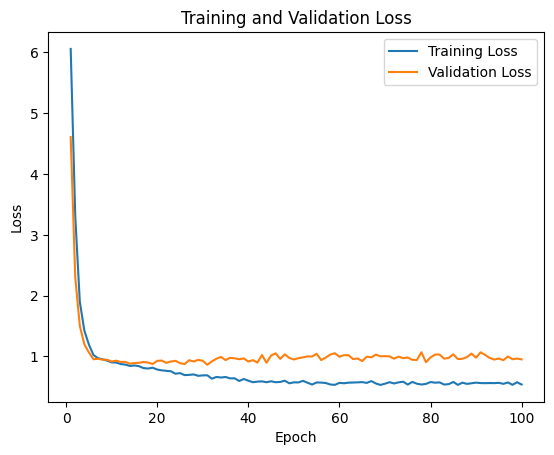

In [28]:
# Create a DataFrame from model_results
results_df = pd.DataFrame(model_results)

# Save the results as a CSV file
results_csv_path = os.path.join(results_path, f'model_results_{last_folder}.csv')
results_df.to_csv(results_csv_path, index=False)

# Save the Matplotlib figure with the same basename as the saved model
figure_name =  f'Train_Val_Curve_{last_folder}.png'
figure_path = os.path.join(results_path, figure_name)
# Plot the losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(figure_path)
plt.show()

# 4 Train Persons AIO

### 4.1 Define Model, Dataset and Parameters

In [137]:
image_size=256
patch_size=16
num_classes=5  # Number of classes for image quality levels
dim=1024
depth=6
heads=16
mlp_dim=2048
emb_dropout=0.1

# pretrained_model_path = None
# pretrained_model_path = 'results/weights/AIO0/vit_model_20230911_064440_epoch_148of150_valLoss_0.108_valAcc_0.953_batchsize_128_lr_0.0_allDistorted.pth'
pretrained_model_path = 'results/weights/FINAL/AIO5/AIO5_2/vit_model_20231204_153455_epoch_16of100_valLoss_1.094_valAcc_0.600_batchsize_128_lr_0.0_DS5.pth'
num_epochs = 100
results_path = 'results/weights/FINAL/AIO5/AIO5_3'
os.makedirs(results_path, exist_ok=True)

train_dataset_root  = 'assets/Dataset/DS5'
val_dataset_root  = 'assets/Test/DSX'
train_csv_file = 'assets/Obs_iterative/Obs5/Obs5_3.csv'
val_csv_file = 'assets/Test/Obs5.csv'

In [138]:
learning_rate = 2.5e-5
batch_size = 128

In [139]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

In [140]:
model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    emb_dropout=emb_dropout
)
if pretrained_model_path is not None:
    model.load_state_dict(torch.load(pretrained_model_path))

train_dataset = ImageQualityDataset(train_csv_file,train_dataset_root, transform=transform)
val_dataset = ImageQualityDataset(val_csv_file,val_dataset_root, transform=transform)

Number of images in class 0: 87
Number of images in class 1: 91
Number of images in class 2: 78
Number of images in class 3: 39
Number of images in class 4: 5

Number of images in the dataset: 300
Number of images in class 0: 77
Number of images in class 1: 89
Number of images in class 2: 89
Number of images in class 3: 37
Number of images in class 4: 8

Number of images in the dataset: 300


In [141]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
mse_criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# KL-Divergence
kl_div_criterion = nn.KLDivLoss(reduction='batchmean')

In [142]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
best_val_loss = float('inf')
best_model_weights = None

### 4.2 Train AIO

In [144]:
train_losses = []
val_losses = []
    
# Initialize a list to store model results
model_results = []
print("Starting training...")
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for _, (images, _, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        true_distributions = calculate_true_distributions(labels, device=device)
        # true_distributions = labels

        # loss = criterion(outputs, labels)
        loss = criterion(outputs, true_distributions)

        # log_model_dist = torch.nn.functional.log_softmax(outputs, dim=1)
        # loss = kl_div_criterion(log_model_dist, true_distributions)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)  # Get predicted labels
        train_preds.extend(preds.cpu().numpy())  # Extend the list of predictions
        train_labels.extend(labels.cpu().numpy())  # Extend the list of true labels
    train_accuracy = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for _, (images, _, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            true_distributions = calculate_true_distributions(labels=labels, device=device)
            # true_distributions = labels
            # CROSS-ENTROPY
            outputs = model(images)
            loss = criterion(outputs, true_distributions)

            # log_model_dist = torch.nn.functional.log_softmax(outputs, dim=1)
            # loss = kl_div_criterion(log_model_dist, true_distributions)

            # loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)  # Get predicted labels
            val_preds.extend(preds.cpu().numpy())  # Extend the list of predictions
            val_labels.extend(labels.cpu().numpy())  # Extend the list of true labels



    val_accuracy = accuracy_score(val_labels, val_preds)
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Acc: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.4f}')
    # Step the ReduceLROnPlateau scheduler with the validation loss
    scheduler.step(val_loss)
    # Calculate and store the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    
    # Save the weights with the best validation loss
    if val_loss < best_val_loss:
        # Delete the previously saved best model
        #if best_model_weights is not None:
        #    os.remove(best_model_path)

        # Update the best validation loss and save the new best model
        best_val_loss = val_loss
        best_model_weights = model.state_dict().copy()

        # Get the current timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        last_folder = os.path.basename(train_dataset_root)
        # Use the timestamp and transfer learning information as a name extension
        model_name = f"vit_model_{timestamp}_epoch_{epoch+1}of{num_epochs}_valLoss_{best_val_loss:.3f}_valAcc_{val_accuracy:.3f}_batchsize_{batch_size}_lr_{learning_rate:.1f}_{last_folder}.pth"
        best_model_path = os.path.join(results_path, model_name)
        torch.save(best_model_weights, best_model_path)
        
        # After saving the best model
        model_info = {
            'model_name': model_name,
            'validation_loss': val_loss,
            'validation_accuracy': val_accuracy,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epoch': epoch + 1
        }
        model_results.append(model_info)

Starting training...
Epoch [1/100], Training Loss: 1.1224, Training Acc: 0.5633, Validation Loss: 1.0948, Validation Acc: 0.5900
Epoch [2/100], Training Loss: 1.0256, Training Acc: 0.6100, Validation Loss: 1.0838, Validation Acc: 0.5833
Epoch [3/100], Training Loss: 0.9620, Training Acc: 0.6567, Validation Loss: 1.0849, Validation Acc: 0.5833
Epoch [4/100], Training Loss: 0.9221, Training Acc: 0.6867, Validation Loss: 1.0629, Validation Acc: 0.6067
Epoch [5/100], Training Loss: 0.8932, Training Acc: 0.7200, Validation Loss: 1.0587, Validation Acc: 0.6067
Epoch [6/100], Training Loss: 0.8659, Training Acc: 0.7633, Validation Loss: 1.0551, Validation Acc: 0.6033
Epoch [7/100], Training Loss: 0.8391, Training Acc: 0.7933, Validation Loss: 1.0754, Validation Acc: 0.5933
Epoch [8/100], Training Loss: 0.8126, Training Acc: 0.8000, Validation Loss: 1.0807, Validation Acc: 0.5933
Epoch [9/100], Training Loss: 0.7997, Training Acc: 0.8267, Validation Loss: 1.0760, Validation Acc: 0.5900
Epoch [

Save results

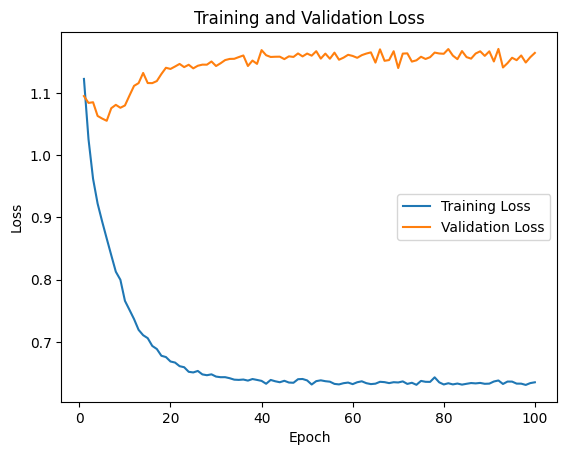

In [145]:
# Extract the digit from the CSV file name
digit = ''.join(filter(str.isdigit, train_csv_file))

# Create a DataFrame from model_results
results_df = pd.DataFrame(model_results)

# Save the results as a CSV file
results_csv_path = os.path.join(results_path, f'training_results_AIO{digit}.csv')
results_df.to_csv(results_csv_path, index=False)


# Save the Matplotlib figure with the same basename as the saved model
figure_name =  f'Train_Val_Curve_AIO{digit}.png'
figure_path = os.path.join(results_path, figure_name)
# Plot the losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(figure_path)
plt.show()